# 1. Evaluation of Hyperparameters

## 1.1 How many hyperparameters are chosen the same?

We run experiments for both stratified and unstratified cross-validation, while the hyperparameter grid stays the same. We have 200 iterations, i.e. 200 different hyperparameter combinations (same options for statified and unstratified). Now we want to evaluate how many times the two methods chose the same hyperparameters.

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
# remove waringns
import warnings
warnings.filterwarnings("ignore")


from utils_evaluation import flatten_data

In [53]:
def read_data(json_path):
    json_files = os.listdir(json_path)
    data = []
    for file in json_files:
        with open(json_path + file) as f:
            data_new = json.load(f)
            data = data + data_new
    # flatten dictionary and convert to dataframe
    data_all_flatten, keys_dic = flatten_data(data)
    data = pd.DataFrame(data_all_flatten)
    return data


In [54]:
json_path ="../results/rf/"
json_path_xgb = "../results/xgb/"

data_rf = read_data(json_path)
data_xgb = read_data(json_path_xgb)

print('\nData Loading from json file:')
print('Loaded Random Forest data from json file: shape', data_rf.shape)
print('Loaded XGBoost data from json file: shape', data_xgb.shape)


Data Loading from json file:
Loaded Random Forest data from json file: shape (4800, 75)
Loaded XGBoost data from json file: shape (4800, 87)


In [20]:
data_rf.head()

,model_info_model,model_info_n_train,model_info_n_test,model_info_n_features,model_info_noise,model_info_transformation,model_info_group_size,model_info_n_folds,model_info_n_iter,model_info_n_repetitions,...,cv_folds_descriptives_unstratified_intersection_area,cv_folds_descriptives_stratified_ks_statistic,cv_folds_descriptives_stratified_p_value,cv_folds_descriptives_stratified_intersection_area,unstratified_best_params_min_samples_split,unstratified_best_params_min_samples_leaf,unstratified_best_params_max_features,stratified_best_params_min_samples_split,stratified_best_params_min_samples_leaf,stratified_best_params_max_features
0,rf,200,100000,8,0,identity,5,5,200,20,...,0.866526,0.025,1.0,0.962943,2,1,5,4,1,7
1,rf,200,100000,8,0,identity,5,5,200,20,...,0.851083,0.025,1.0,0.952666,3,1,5,3,1,5
2,rf,200,100000,8,0,identity,5,5,200,20,...,0.892708,0.025,1.0,0.955146,2,1,7,3,1,6
3,rf,200,100000,8,0,identity,5,5,200,20,...,0.858054,0.025,1.0,0.954002,2,1,4,2,1,6
4,rf,200,100000,8,0,identity,5,5,200,20,...,0.847100,0.025,1.0,0.940897,3,1,6,4,1,5


In [55]:
models = ['rf', 'xgb']
for model in models:
    if model == 'rf':
        data = data_rf
    else:
        data = data_xgb
    print(f"Percentage of different hyperparameter combinations of {model}: ", round(data.hyperparameters_same.value_counts()[0] / data.shape[0], 2))

    print(data.hyperparameters_same.value_counts())
    print("\n")

Percentage of different hyperparameter combinations of rf:  0.66
hyperparameters_same
False    3155
True     1645
Name: count, dtype: int64


Percentage of different hyperparameter combinations of xgb:  0.77
hyperparameters_same
False    3711
True     1089
Name: count, dtype: int64




In [56]:
df_plot1 = pd.concat([data_rf[['model_info_model', 'hyperparameters_same']], data_xgb[['model_info_model', 'hyperparameters_same']]], axis=0)

In [57]:

# Group by model_info_model and hyperparameters_same, then count occurrences
grouped_data = df_plot1.groupby(['model_info_model', 'hyperparameters_same']).size().unstack(fill_value=0)
grouped_data = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100
grouped_data


hyperparameters_same,False,True
model_info_model,,
rf,65.729167,34.270833
xgb,77.312500,22.687500


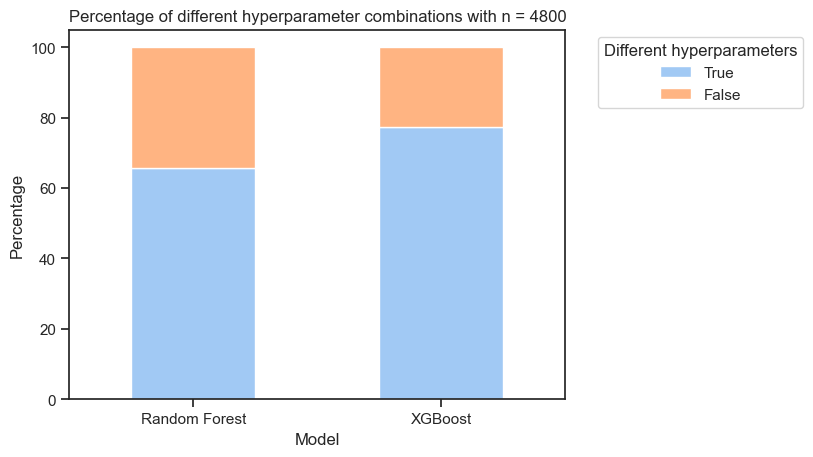

In [58]:
# Plot the stacked bar chart
grouped_data.plot(kind='bar', stacked=True)
plt.xlabel('Model')
plt.ylabel('Percentage')
plt.title('Percentage of different hyperparameter combinations with n = 4800')
plt.legend(title='Different hyperparameters', labels=['True', 'False'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks([0, 1], ['Random Forest', 'XGBoost'], rotation=0)
plt.show()

## 1.2 Boxplots of best hyperparameters

We saw that 66% and 77% of Random Forest and XGBoost respectively have different best hyperparameters for stratified vs. unstratified. Now we want to see what hyperparameters were chosen in the end (per model) by using boxplots.

### 1.2.1 Random Forest

In [59]:
data_rf.columns

Index(['model_info_model', 'model_info_n_train', 'model_info_n_test',
       'model_info_n_features', 'model_info_noise',
       'model_info_transformation', 'model_info_group_size',
       'model_info_n_folds', 'model_info_n_iter', 'model_info_n_repetitions',
       'model_info_scoring', 'model_info_n_jobs', 'model_info_json_file',
       'repetition', 'random_state', 'hyperparameters_same',
       'unstratified_results_train r2', 'unstratified_results_test r2',
       'unstratified_results_train mse', 'unstratified_results_test mse',
       'unstratified_results_train mae', 'unstratified_results_test mae',
       'stratified_results_train r2', 'stratified_results_test r2',
       'stratified_results_train mse', 'stratified_results_test mse',
       'stratified_results_train mae', 'stratified_results_test mae',
       'cv_unstratified_iterations_mean_fit_time',
       'cv_unstratified_iterations_std_fit_time',
       'cv_unstratified_iterations_mean_score_time',
       'cv_unstratifie

In [60]:
data_plot2 = data_rf[['unstratified_best_params_min_samples_split',
                      'stratified_best_params_min_samples_split',
                      'unstratified_best_params_min_samples_leaf',
                      'stratified_best_params_min_samples_leaf',
                      'unstratified_best_params_max_features',
                      'stratified_best_params_max_features']]
data_plot2.shape

(4800, 6)

In [83]:
def plot_hyperparams(data, hyperparam):
    # Melt the dataframe to make it suitable for boxplot
    melted_df = pd.melt(data[[f'unstratified_best_params_{hyperparam}', f'stratified_best_params_{hyperparam}']], var_name='Hyperparameter', value_name='Value')
    data_plot = melted_df.groupby(['Hyperparameter', 'Value']).value_counts().reset_index()
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Value", y="count", hue="Hyperparameter", data=data_plot3)

    # Add labels and title
    plt.xlabel("Value")
    plt.ylabel("Hyperparameter")
    plt.title("Grouped barplot of best chosen hyperparameter {}".format(hyperparam))
    plt.show()

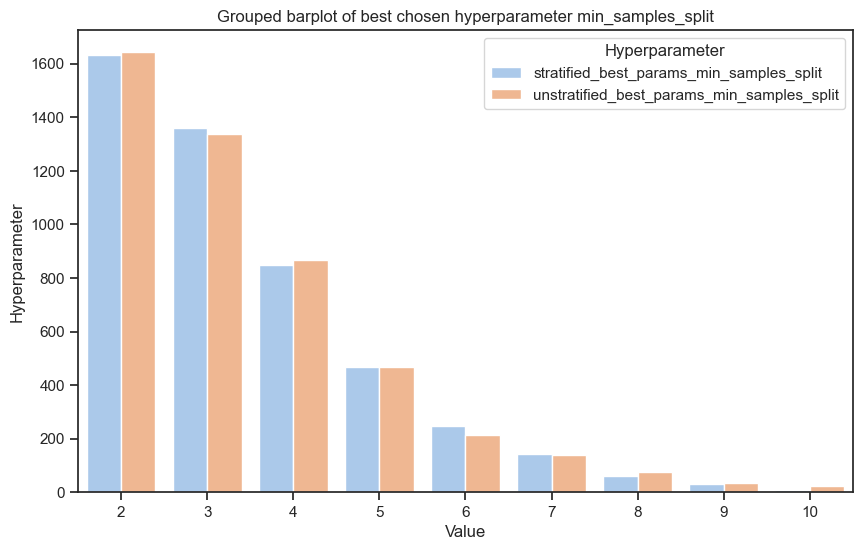

In [84]:
plot_hyperparams(data_rf, 'min_samples_split')

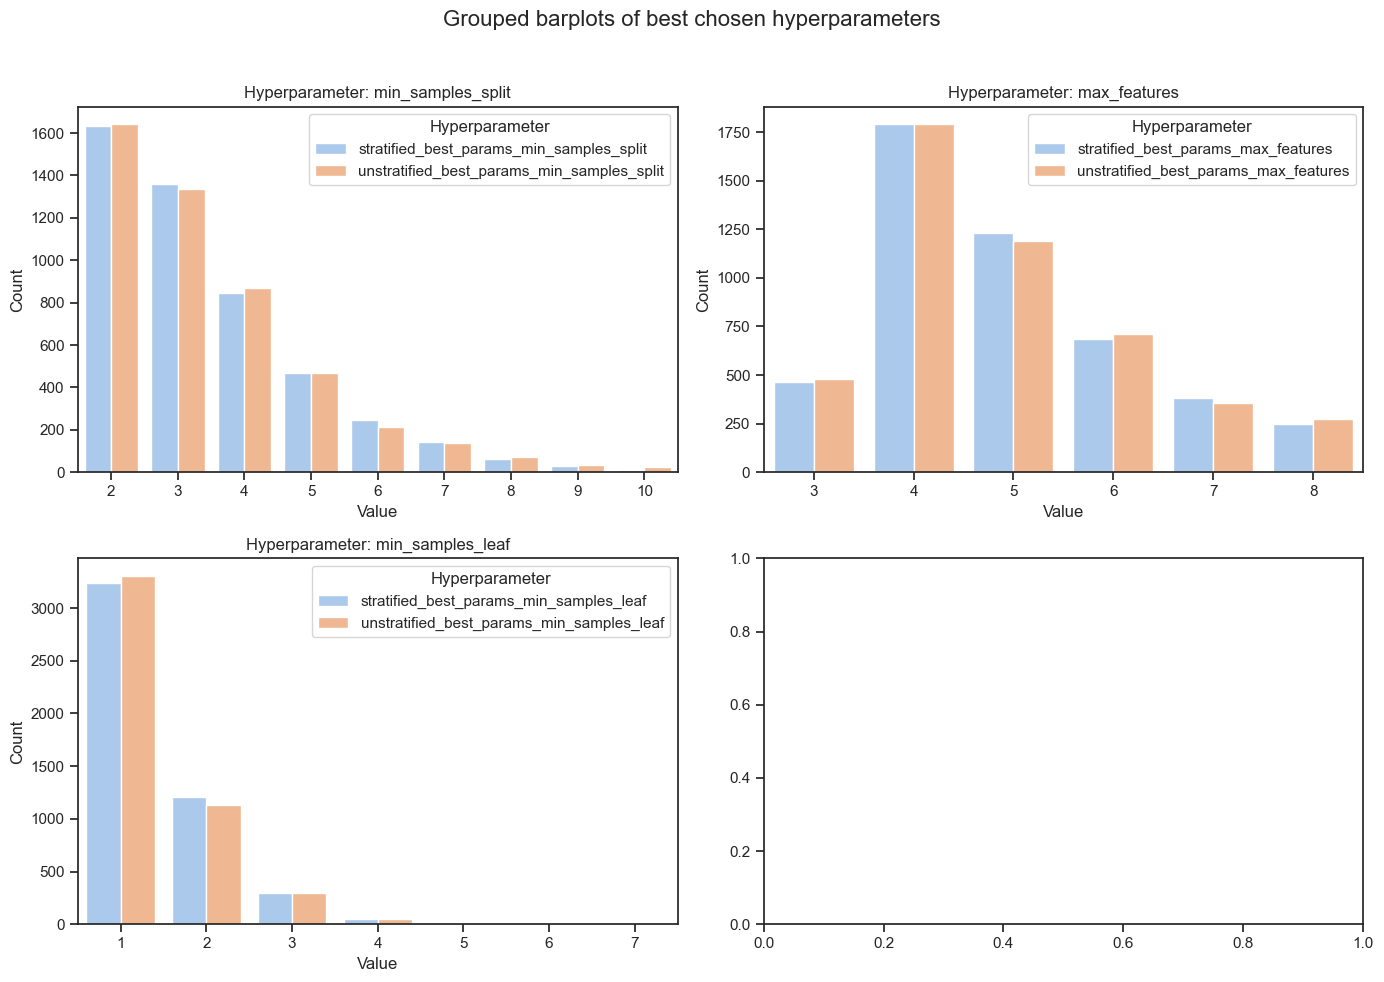

In [106]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_hyperparams(data, hyperparams, nrows, ncols, histo = False):
    # Create a grid for subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 10))
    fig.suptitle("Grouped barplots of best chosen hyperparameters", fontsize=16)

    # Flatten the array of subplots
    axes = axes.flatten()

    for i, hyperparam in enumerate(hyperparams):
        # Melt the dataframe to make it suitable for boxplot
        melted_df = pd.melt(data[[f'unstratified_best_params_{hyperparam}', f'stratified_best_params_{hyperparam}']], var_name='Hyperparameter', value_name='Value')
        data_plot = melted_df.groupby(['Hyperparameter', 'Value']).value_counts().reset_index()

        # Select the current subplot
        ax = axes[i]
        if histo:
            # Create a grouped histogram for the current hyperparameter
            sns.histplot(data_plot, x="Value", hue="Hyperparameter", multiple="stack", ax=ax, bins=30, kde=True)
            # Add labels and title to the subplot
            ax.set_xlabel(hyperparam)
            ax.set_ylabel("Count")
            ax.set_title(f"Hyperparameter: {hyperparam}")
        else:
            # Create a grouped barplot for the current hyperparameter
            sns.barplot(x="Value", y="count", hue="Hyperparameter", data=data_plot, ax=ax)

            # Add labels and title to the subplot
            ax.set_xlabel("Value")
            ax.set_ylabel("Count")
            ax.set_title(f"Hyperparameter: {hyperparam}")

    # Adjust layout and show the plot
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Example usage
hyperparams_list = ['min_samples_split', 'max_features', 'min_samples_leaf']
plot_hyperparams(data_rf, hyperparams_list, nrows=2, ncols=2)


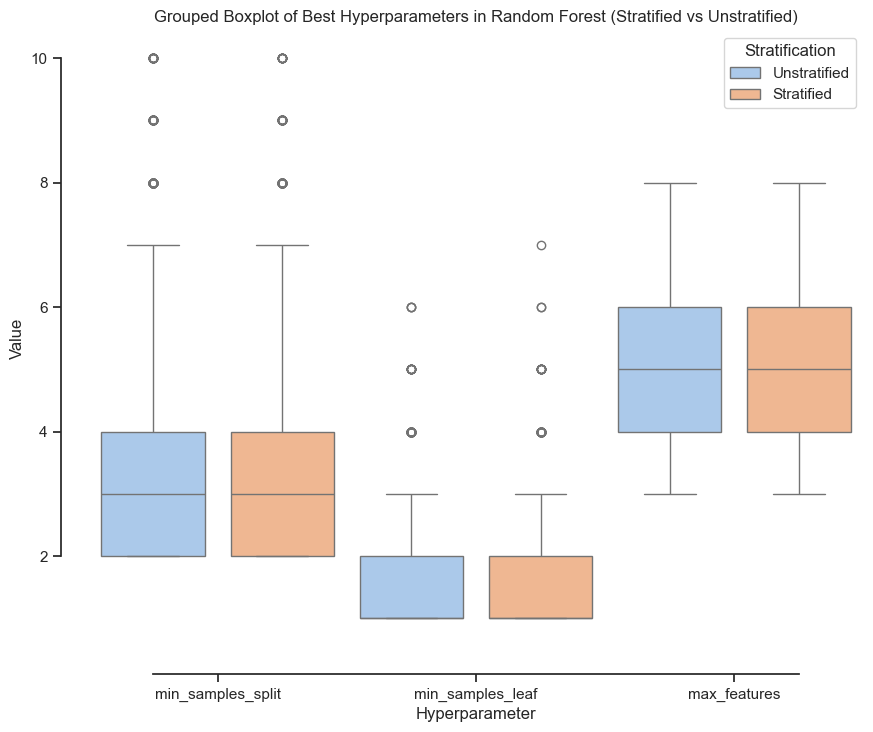

In [32]:
# Melt the dataframe to make it suitable for boxplot
melted_df = pd.melt(data_plot2, var_name='Hyperparameter', value_name='Value')


# Add a column indicating whether it's stratified or unstratified
melted_df['Stratification'] = ['Unstratified' if 'unstratified' in col else 'Stratified' for col in melted_df['Hyperparameter']]


# Create a nested boxplot
plt.figure(figsize=(10, 8))
sns.boxplot(x='Hyperparameter', y='Value', hue='Stratification',  data=melted_df)
sns.despine(offset=20, trim=True)
plt.title('Grouped Boxplot of Best Hyperparameters in Random Forest (Stratified vs Unstratified)')
plt.xlabel('Hyperparameter')
plt.ylabel('Value')
plt.xticks([0.5, 2.5, 4.5], ['min_samples_split', 'min_samples_leaf', 'max_features'])
plt.show()

import seaborn as sns



### 1.2.2 XGBoost

In [33]:
data_xgb.columns

Index(['model_info_model', 'model_info_n_train', 'model_info_n_test',
       'model_info_n_features', 'model_info_noise',
       'model_info_transformation', 'model_info_group_size',
       'model_info_n_folds', 'model_info_n_iter', 'model_info_n_repetitions',
       'model_info_scoring', 'model_info_n_jobs', 'model_info_json_file',
       'repetition', 'random_state', 'hyperparameters_same',
       'unstratified_results_train r2', 'unstratified_results_test r2',
       'unstratified_results_train mse', 'unstratified_results_test mse',
       'unstratified_results_train mae', 'unstratified_results_test mae',
       'stratified_results_train r2', 'stratified_results_test r2',
       'stratified_results_train mse', 'stratified_results_test mse',
       'stratified_results_train mae', 'stratified_results_test mae',
       'cv_unstratified_iterations_mean_fit_time',
       'cv_unstratified_iterations_std_fit_time',
       'cv_unstratified_iterations_mean_score_time',
       'cv_unstratifie

In [92]:
df_plot3 = data_xgb[['unstratified_best_params_max_depth',
                     'stratified_best_params_max_depth',
                     'unstratified_best_params_min_child_weight',
                     'stratified_best_params_min_child_weight',
                     'unstratified_best_params_gamma',
                     'stratified_best_params_gamma',
                     'unstratified_best_params_subsample',
                     'stratified_best_params_subsample',
                     'unstratified_best_params_colsample_bytree',
                     'stratified_best_params_colsample_bytree',
                     'unstratified_best_params_learning_rate',
                     'stratified_best_params_learning_rate']]
df_plot3.shape

(4800, 12)

In [44]:
order = ['unstratified_best_params_max_depth',
                     'stratified_best_params_max_depth',
                     'unstratified_best_params_min_child_weight',
                     'stratified_best_params_min_child_weight',
                     'unstratified_best_params_gamma',
                     'stratified_best_params_gamma',
                     'unstratified_best_params_subsample',
                     'stratified_best_params_subsample',
                     'unstratified_best_params_colsample_bytree',
                     'stratified_best_params_colsample_bytree',
                     'unstratified_best_params_learning_rate',
                     'stratified_best_params_learning_rate']

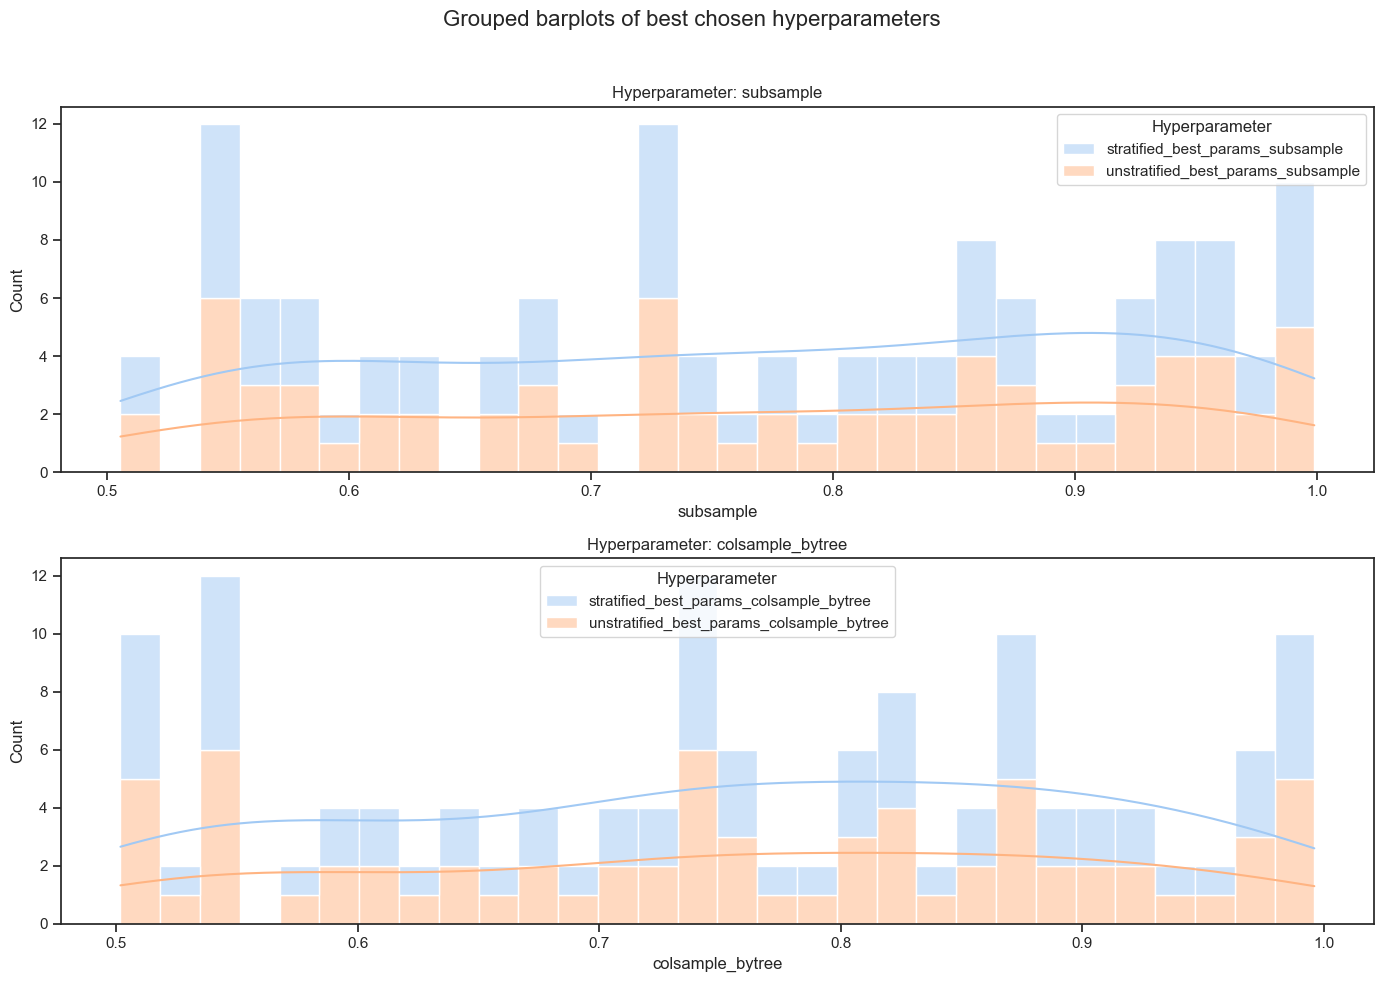

In [107]:
#order = ['max_depth', 'min_child_weight', 'gamma', 'learning_rate']
order = ['subsample', 'colsample_bytree']
plot_hyperparams(data_xgb, order, nrows=2, ncols=1, histo=True)

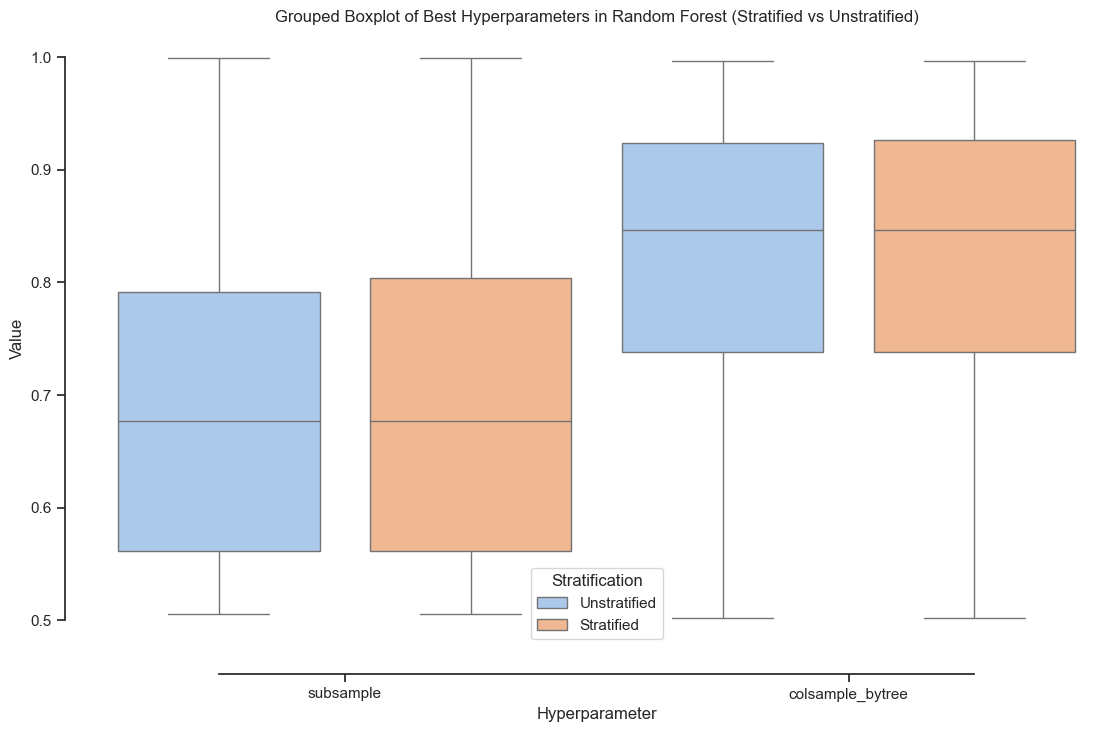

In [93]:
# Melt the dataframe to make it suitable for boxplot
melted_df = pd.melt(df_plot3[['unstratified_best_params_subsample',
                     'stratified_best_params_subsample',
                     'unstratified_best_params_colsample_bytree',
                     'stratified_best_params_colsample_bytree']], var_name='Hyperparameter', value_name='Value')


# Add a column indicating whether it's stratified or unstratified
melted_df['Stratification'] = ['Unstratified' if 'unstratified' in col else 'Stratified' for col in melted_df['Hyperparameter']]


# Create a nested boxplot
plt.figure(figsize=(13, 8))
sns.boxplot(x='Hyperparameter', y='Value', hue='Stratification',  data=melted_df)
sns.despine(offset=20, trim=True)
plt.title('Grouped Boxplot of Best Hyperparameters in Random Forest (Stratified vs Unstratified)')
plt.xlabel('Hyperparameter')
plt.ylabel('Value')
plt.xticks([0.5, 2.5], ['subsample', 'colsample_bytree'])
plt.show()


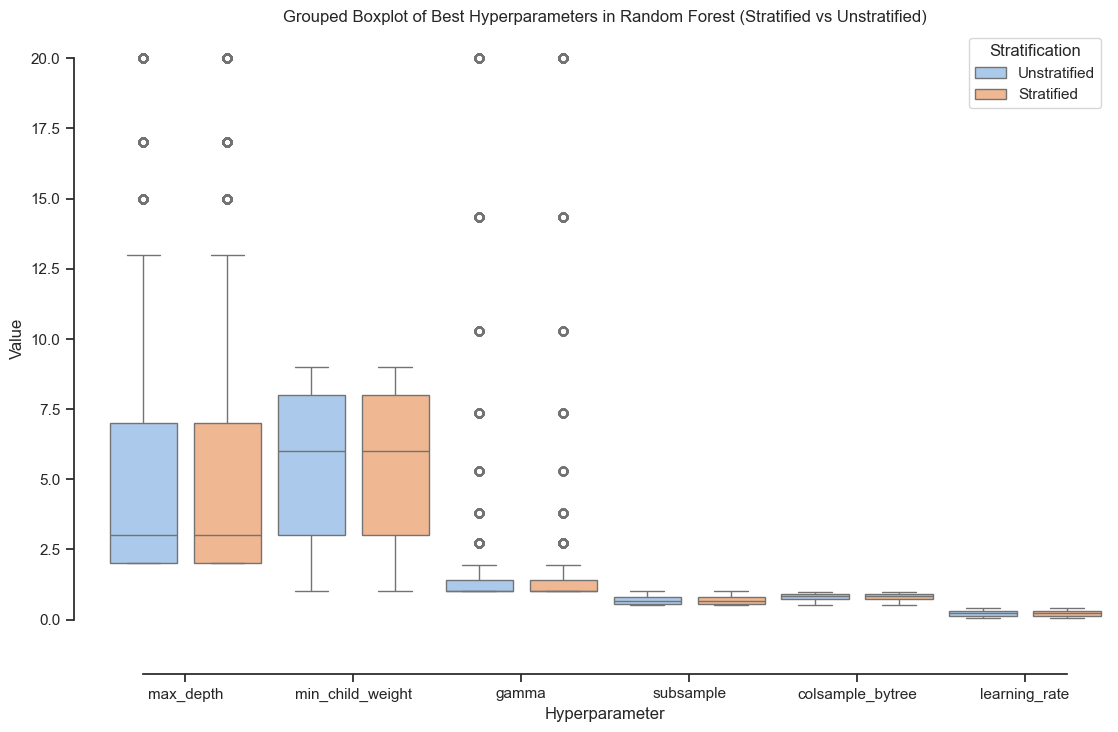

In [36]:
# Melt the dataframe to make it suitable for boxplot
melted_df = pd.melt(df_plot3, var_name='Hyperparameter', value_name='Value')


# Add a column indicating whether it's stratified or unstratified
melted_df['Stratification'] = ['Unstratified' if 'unstratified' in col else 'Stratified' for col in melted_df['Hyperparameter']]


# Create a nested boxplot
plt.figure(figsize=(13, 8))
sns.boxplot(x='Hyperparameter', y='Value', hue='Stratification',  data=melted_df)
sns.despine(offset=20, trim=True)
plt.title('Grouped Boxplot of Best Hyperparameters in Random Forest (Stratified vs Unstratified)')
plt.xlabel('Hyperparameter')
plt.ylabel('Value')
plt.xticks([0.5, 2.5, 4.5, 6.5, 8.5, 10.5], ['max_depth', 'min_child_weight', 'gamma', 'subsample', 'colsample_bytree', 'learning_rate'])
plt.show()



In [39]:
melted_df

,Hyperparameter,Value,Stratification
0,unstratified_best_params_max_depth,2.000000,Unstratified
1,unstratified_best_params_max_depth,2.000000,Unstratified
2,unstratified_best_params_max_depth,2.000000,Unstratified
3,unstratified_best_params_max_depth,2.000000,Unstratified
4,unstratified_best_params_max_depth,2.000000,Unstratified
...,...,...,...
57595,stratified_best_params_learning_rate,0.178333,Stratified
57596,stratified_best_params_learning_rate,0.134000,Stratified
57597,stratified_best_params_learning_rate,0.178333,Stratified
57598,stratified_best_params_learning_rate,0.178333,Stratified


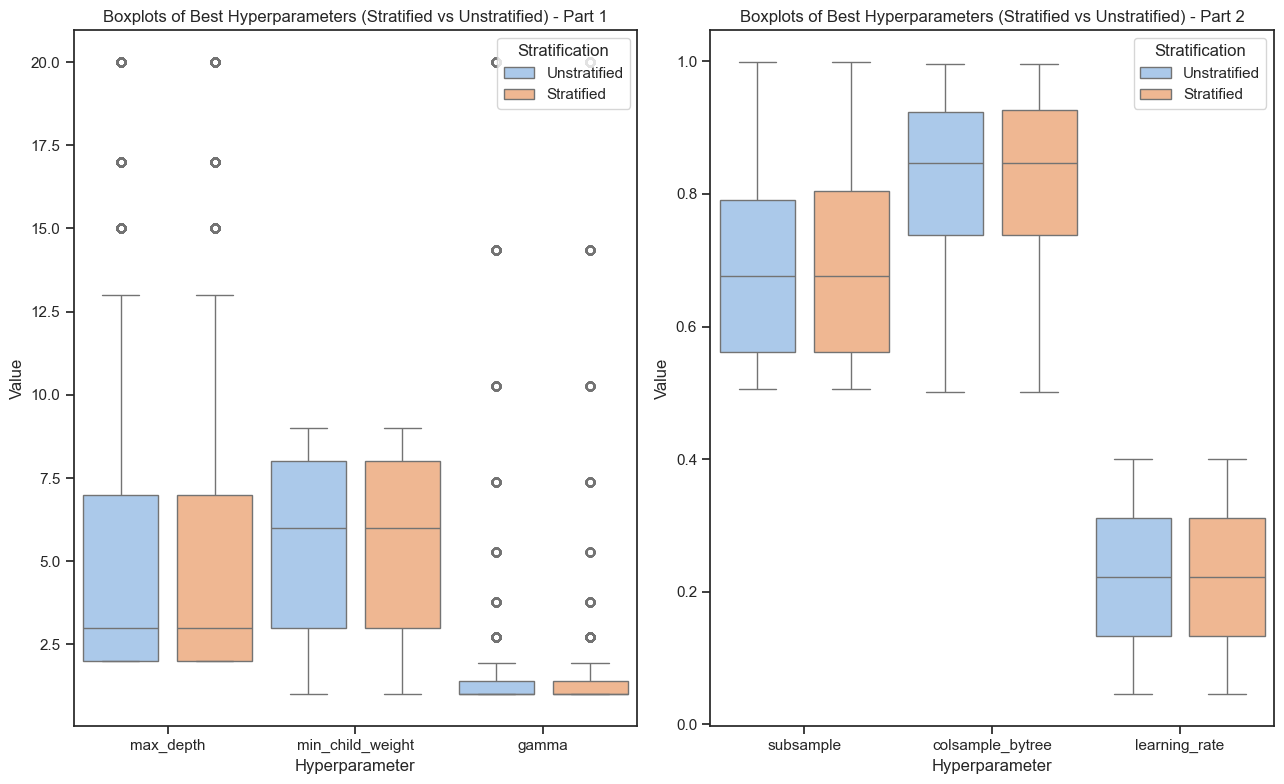

In [51]:
# Melt the dataframe to make it suitable for boxplot
melted_df = pd.melt(df_plot3, var_name='Hyperparameter', value_name='Value')

# Add a column indicating whether it's stratified or unstratified
melted_df['Stratification'] = ['Unstratified' if 'unstratified' in col else 'Stratified' for col in melted_df['Hyperparameter']]

# Define the order of hyperparameters
hyperparameter_order = order

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 8))

# Create boxplots for the first 6 hyperparameters in the first subplot
sns.boxplot(x='Hyperparameter', y='Value', hue='Stratification', data=melted_df[melted_df['Hyperparameter'].isin(hyperparameter_order[:6])], ax=axes[0])
axes[0].set_title('Boxplots of Best Hyperparameters (Stratified vs Unstratified) - Part 1')
axes[0].set_xlabel('Hyperparameter')
axes[0].set_ylabel('Value')
axes[0].set_xticks([0.5, 2.5, 4.5], ['max_depth', 'min_child_weight', 'gamma'])
axes[0].legend(title='Stratification', loc='upper right')

# Create boxplots for the remaining 6 hyperparameters in the second subplot
sns.boxplot(x='Hyperparameter', y='Value', hue='Stratification', data=melted_df[melted_df['Hyperparameter'].isin(hyperparameter_order[6:])], ax=axes[1])
axes[1].set_title('Boxplots of Best Hyperparameters (Stratified vs Unstratified) - Part 2')
axes[1].set_xlabel('Hyperparameter')
axes[1].set_ylabel('Value')
axes[1].set_xticks([0.5, 2.5, 4.5], ['subsample', 'colsample_bytree', 'learning_rate'])
axes[1].legend(title='Stratification', loc='upper right')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()